# 新闻分类: 多分类问题

上一节面对的评论只有两个分类,这一节则要面对 46 个类别.具体而言这一节是单标签的多分类问题,即每个样本只有属于一个类别.(single-label,  multiclass  classification)


# 准备数据

路透社数据集

- 1986 年发布的包含短新闻和主题的数据集
- 46 个主题/类别
- 每个主题至少有 10 个样本,每个样本只属于一个主题/类别


In [1]:
from keras.datasets import reuters

(train_data, train_labels), \
    (test_data,test_labels) = reuters.load_data(num_words=10000) #限定词频最高的 10000 个单词

如 imdb 数据集,依旧是取词频最高的前 10000 个词.


In [2]:
print(len(train_data), len(test_data))

8982 2246


训练数据有 8982 条,测试数据有 2246 条

In [3]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


一个样本是整数的 list.

In [4]:
word_index = reuters.get_word_index()  # 取字典
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()
                           ])  #key value 取反
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") \
                                for i in train_data[0]]) # 与 imdb 数据集相同,原 list 对应字典 0 1 2 为 padding start  of  sequence unknown 保留
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [5]:
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # 初始化全 0 2d 张量
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1  #sequences 第 i 个整数序列包含的整数值在 results 中的位置设为 1
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

这是从整数 list -> 字符串的转换,索引减 3 是原 list 对应字典 0 1 2 为 padding start  of  sequence unknown 保留.

In [6]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

整数数组无法输入神经网络,必须转换成张量.

- 所有数组填充到同样长度,转换成整数张量.keras 有专门能接受这样输入的 layer.
- 使用 1D 10000 维的张量表示整数 list.list 内有那些整数,这些位置就是 1,其他位置都是 0.所谓的 one-hot 编码.

与上一节不同,这里直接使用了 keras 内置的函数完成 one-hot 编码.


## 构建模型

与 imdb 的例子相比

- 都是对文本的分类问题,输入都是整数 list 处理而来的张量.
- 分类的输出从 2 增加到了 46 种.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

2022-04-27 06:13:07.961614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-27 06:13:07.995429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-27 06:13:07.995704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-27 06:13:07.996306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

与 imdb model 的变换

- 处理的张量类型没有变化,所以 layer 种类,排列没有变换.激活函数没有变换.
- 但是隐藏层的单元增加到了 64,最后输出是 46 种类别,隐藏层单元 16 可表示的假设空间太小了.一旦某些重要信息在中间层丢失,那永远也找不回来了,必须加大假设空间.
- 2 分类最后输出的是标量概率就够了,而 46 分类标量远远不够.输出层的激活函数变成了 softmax,输出的是概率张量,1d 46 维,总和为 1.


In [8]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

对于分类问题,损失函数最好的是 categorical_crossentropy (分类交叉熵),具体原理是什么?

这里仅引用第一版的说明: 它用于衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签.


## 训练 model

In [9]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

取前 1000 个作为验证集.

In [10]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,  # 训练20轮肯定过拟合,不过是验证模型而已
    batch_size=512,
    validation_data=(x_val, y_val))


Epoch 1/20
16/16 [==============================] - 2s 25ms/step - loss: 2.6876 - accuracy: 0.5606 - val_loss: 1.7883 - val_accuracy: 0.6680
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 1.4383 - accuracy: 0.7137 - val_loss: 1.3660 - val_accuracy: 0.7080
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.0675 - accuracy: 0.7731 - val_loss: 1.1703 - val_accuracy: 0.7530
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8495 - accuracy: 0.8234 - val_loss: 1.0845 - val_accuracy: 0.7750
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6795 - accuracy: 0.8628 - val_loss: 1.0004 - val_accuracy: 0.7980
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.5521 - accuracy: 0.8885 - val_loss: 0.9448 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.4483 - accuracy: 0.9094 - val_loss: 0.9214 - val_accuracy: 0.8150
Epoch 8/20
16

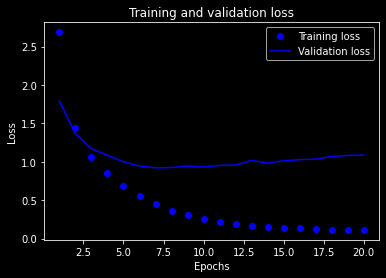

In [11]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

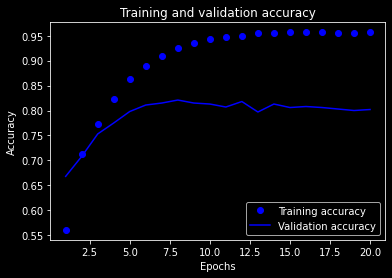

In [12]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

大约是第 9 轮开始是过拟合的拐点,因此模型训练迭代 9 次为好.


In [13]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

Epoch 1/9
18/18 [==============================] - 1s 12ms/step - loss: 2.6448 - accuracy: 0.5119
Epoch 2/9
18/18 [==============================] - 0s 13ms/step - loss: 1.3820 - accuracy: 0.7241
Epoch 3/9
18/18 [==============================] - 0s 12ms/step - loss: 0.9865 - accuracy: 0.7948
Epoch 4/9
18/18 [==============================] - 0s 12ms/step - loss: 0.7654 - accuracy: 0.8456
Epoch 5/9
18/18 [==============================] - 0s 12ms/step - loss: 0.6044 - accuracy: 0.8740
Epoch 6/9
18/18 [==============================] - 0s 12ms/step - loss: 0.4844 - accuracy: 0.8999
Epoch 7/9
18/18 [==============================] - 0s 14ms/step - loss: 0.3937 - accuracy: 0.9155
Epoch 8/9
18/18 [==============================] - 0s 12ms/step - loss: 0.3223 - accuracy: 0.9321
Epoch 9/9
18/18 [==============================] - 0s 12ms/step - loss: 0.2706 - accuracy: 0.9385


In [14]:
results = model.evaluate(x_test, y_test)
print(results)

71/71 [==============================] - 1s 8ms/step - loss: 0.9370 - accuracy: 0.7979
[0.9370008707046509, 0.7978628873825073]


In [18]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.1861086375779163

如果是完全随机分类器,二分类问题准确度是 50%,在这个问题上是 18.5%.相比之下这个 model 测试集上的精度 80% 上下.已经算好的了.


## 应用 model


In [19]:
predictions = model.predict(x_test)

In [20]:
predictions[0].shape

(46,)

In [21]:
np.argmax(predictions[0])

3

应用模型的方法还是调用 model.predict,只不过这次返回的是 1d 46 维的张量,取结果要麻烦一点点.


## 另一种处理整数 list 方式


In [20]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

另一种处理数据方式是将其转换成整数张量.


In [21]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

模型不需要大的改动,只是损失函数改为了 `sparse_categorical_crossentropy`,在数学上与 `categorical_crossentropy` 完全相同.


## 结论

N 分类问题,要以 N 大小的密集层为输出.

单标签多任务的问题中,最后一层要使用 softmax 激活函数.最终输出一个 1d 的概率向量.

这一类问题的损失函数清一色是 categorical_crossentropy (分类交叉熵).这在实践中证明过了.

多分类问题处理输入数据

- 转换成整数张量
- 通过 one-hot 编码再成.

如果类别较多,别吝啬内存,中间层的变量给足,避免丢失关键信息.
